## Connection To Device:

Technical specifications and SoC datasheets
The datasheets and other reference material for ESP8266 chip are available from the vendor site: http://bbs.espressif.
com/viewtopic.php?f=67&t=225 . They are the primary reference for the chip technical specifications, capabilities,
operating modes, internal functioning, etc.
For your convenience, some of technical specifications are provided below:

• Architecture: Xtensa lx106

• CPU frequency: 80MHz overclockable to 160MHz

• Total RAM available: 96KB (part of it reserved for system)

• BootROM: 64KB

• Internal FlashROM: None

• External FlashROM: code and data, via SPI Flash. Normal sizes 512KB-4MB.

• GPIO: 16 + 1 (GPIOs are multiplexed with other functions, including external FlashROM, UART, deep sleep
wake-up, etc.)

• UART: One RX/TX UART (no hardware handshaking), one TX-only UART.

• SPI: 2 SPI interfaces (one used for FlashROM).

• I2C: No native external I2C (bitbang implementation available on any pins).

• I2S: 1.

• Programming: using BootROM bootloader from UART. Due to external FlashROM and always-available
BootROM bootloader, ESP8266 is not brickable.



## Startup

The ***%serialconnect to connect*** magic allows you to connect and send data to target device at a specified port and at a specified baud speed.

**Note:**

you may need to set the access rights of the specific port depending on the user and application access, using the following command will open up the port for general use:
    ***# sudo chmod 666 /dev/ttyUSB0***

In [3]:
# %serialconnect --port=/dev/ttyUSB0 --baud=115200
# sudo chmod 666 /dev/ttyUSB0

%serialconnect --port=/dev/ttyUSB0 --baud=115200
# %serialconnect --port=/dev/ttyUSB1 --baud=115200 --raw
import micropython 
import esp
import gc
import utime


# Helper function: list methods and parameter if object
def printd(object):
    print("\nName: ", object.__name__)
    print(dir(object))
    

def time_this(start_time, stop_time):
#     print('stop:', stop_time)
    return (utime.time() - start_time) < stop_time

print('\nHello World :)')
print('Welcome to PrimeTime0416')

print('\n*********************************************')
print('Firmware is good:', esp.check_fw())

hmem_free = gc.mem_free()/1024
hmem_alloc = gc.mem_alloc()/1024
hmem_total = hmem_free + hmem_alloc

fmem_total = esp.flash_size()/1024
fmem_free = esp.freemem()/1024
fmem_id = esp.flash_id()
umem_info = micropython.mem_info()

print('\n*********************************************')
# print('Micropython: Memory Information = {umem_info}'.format(**locals()))
print('Micropython: Memory Information =', umem_info)

print('\n*********************************************')
print('Heap: Allocated Memory = {hmem_alloc}(kb)'.format(**locals()))
print('Heap: Free Memory = {hmem_free}(kb)'.format(**locals()))
print('Heap: Total Memory = {hmem_total}(kb)'.format(**locals()))

print('\n*********************************************')
print('Flash: ID Number = {fmem_id}'.format(**locals()))
print('Flash: Total Memory = {fmem_total}(kb)'.format(**locals()))
print('Flash: Free Memory = {fmem_free}(kb)'.format(**locals()))

printd(micropython)
printd(esp)

Connecting to --port=/dev/ttyUSB0 --baud=115200 
Ready.

Hello World :)
Welcome to PrimeTime0416

*********************************************
size: 604856
md5: 53b9852a38ac9f9e27694b3123fd1420
Firmware is good: True
stack: 2112 out of 8192
GC: total: 35968, used: 11456, free: 24512
 No. of 1-blocks: 34, 2-blocks: 6, max blk sz: 264, max free sz: 1355

*********************************************
Micropython: Memory Information = None

*********************************************
Heap: Allocated Memory = 11.125(kb)
Heap: Free Memory = 24.0(kb)
Heap: Total Memory = 35.125(kb)

*********************************************
Flash: ID Number = 1458415
Flash: Total Memory = 4096.0(kb)
Flash: Free Memory = 10.1719(kb)

Name:  micropython
['__class__', '__name__', 'alloc_emergency_exception_buf', 'const', 'heap_lock', 'heap_unlock', 'kbd_intr', 'mem_info', 'opt_level', 'qstr_info', 'schedule', 'stack_use']

Name:  esp
['__class__', '__name__', 'SLEEP_LIGHT', 'SLEEP_MODEM', 'SLEEP_NONE', 'a

## RTC: SPI

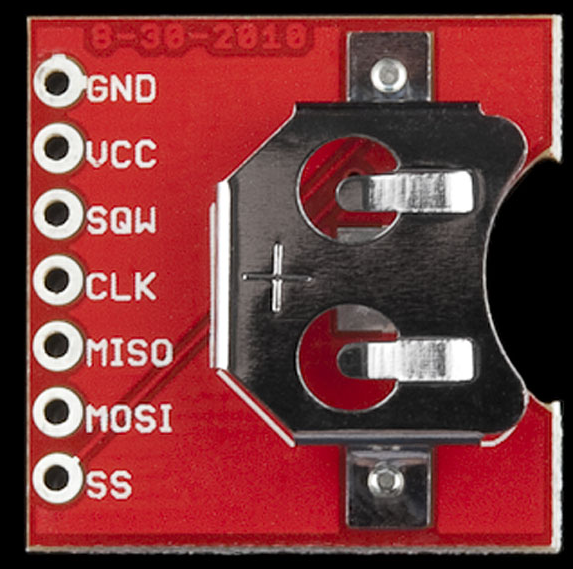
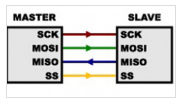

SPI is a synchronous serial protocol that is driven by a master. At the physical level, a bus consists of 3 lines: 
- SCK(14)
- MOSI(13) 
- MISO(12) 

Multiple devices can share the same bus. **Each device should have a separate, 4th signal, SS (Slave
Select)**, to select a particular device on a bus with which communication takes place. Management of an SS signal
should happen in user code (via machine.Pin class).

***buf = bytearray(b'\x00\xF0\xFF') #looks like you have to use the \x00 syntax, best use as buffer***

**buf = bytearray(3) #Buffer**

## SPI Write Transfer

***NOTE: The clock timing needs to be set correctly for the RTC write commands to work***
- **Polarity = 1**
- **Phase = 1**

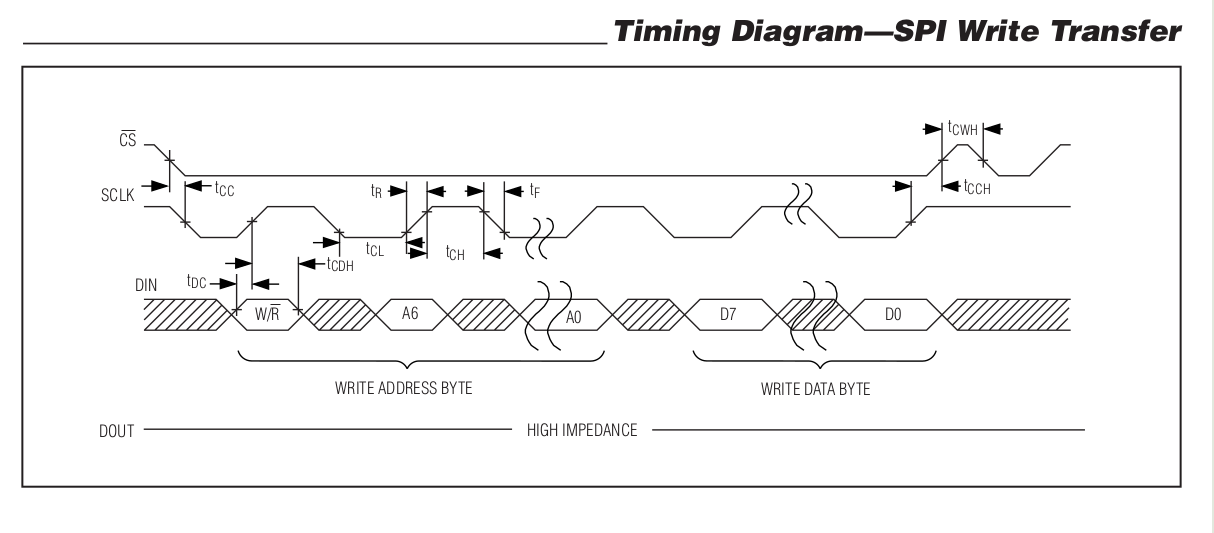

In [131]:
import array
from machine import Pin, SPI

pin16_ss = Pin(16, Pin.OUT)

buf = bytearray(4)
# buf_array = array.array('B', [0x80,0x00, 0x58, 0x23, 0x03, 0x23, 0x01, 0x19 ])
buf_array = array.array('B', [0x85, 0x01])

hspi = SPI(1, baudrate=1000000, polarity=1, phase=1)
hspi.init()
pin16_ss.value(0)
hspi.write(buf_array)
pin16_ss.value(1)

## SPI Read Transfer

In [11]:
import array, utime, os, sys
from machine import Pin, SPI


pin16_ss = Pin(16, Pin.OUT)

buf = bytearray(6)
buf_array = array.array('B', [0x00])

day_ref = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
month_ref ={1:'January', 2:'Febuary', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 
            8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

centery_ref ={0:'20', 1:'19'}
 
hspi = SPI(1)
hspi.init(baudrate=1000000, polarity=1, phase=1)
pin16_ss.value(0)
hspi.write(buf_array)
buf = hspi.read(7, 0x00)
pin16_ss.value(1)

    
def bcd_get(data):
#     print('BCD: ', hex(data))
    return((data >> 4), (data & 0x0F))


def bcd_format(data):
    bcd_data = bcd_get(data)
    return '{0}{1}'.format(bcd_data[0], bcd_data[1])

   
sec_rtc = bcd_format(buf[0])
min_rtc = bcd_format(buf[1])
hour_rtc = bcd_format(buf[2])
day_rtc = day_ref[int(bcd_format(buf[3]))]
date_rtc = bcd_format(buf[4])
month_rtc = month_ref[int(bcd_format(buf[5])) & 0b00011111]
year_rtc = (int(bcd_format(buf[6])))
centery_rtc = centery_ref[int(bcd_format(buf[5])) >> 7]
# centery_rtc = centery_ref[int(bcd_format(0b10010001)) >> 6]

print('{day_rtc} {month_rtc} {date_rtc} {centery_rtc}{year_rtc}, {hour_rtc}:{min_rtc}:{sec_rtc}'.format(**locals()))

print('hello world')


Thursday January 31 2019, 21:48:39
hello world


## RTC: DS3234 Class

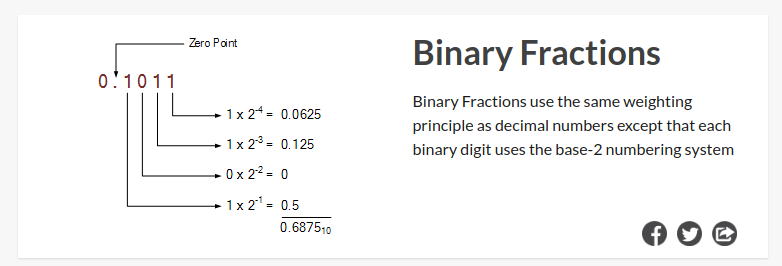

In [64]:
%serialconnect --port=/dev/ttyUSB0 --baud=115200
class DS3234:
    import array
    from machine import Pin, SPI
    
    baudrate= 4000000
    polarity= 1
    phase= 1
    mode = 1
    cs = 16
    reg_time_read =  array.array('B', [0x00])
    reg_time_len = 21
    
    day_string = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    month_string = ['January', 'Febuary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    
    day_ref = dict(enumerate(day_string,start=1))
    month_ref =dict(enumerate(month_string, start=1))
    centery_ref ={0:'20', 1:'19'}
    
    
    
    def __init__(this, spi_cs=cs, spi_baud=baudrate, spi_polarity=polarity, spi_phase=phase, spi_mode=mode):
        this.spi_meta ={}
        this.spi_meta['baud']= spi_baud
        this.spi_meta['polarity']= spi_polarity
        this.spi_meta['phase']= spi_phase
        this.spi_meta['mode']= spi_mode
        this.spi_meta['cs']= spi_cs
        this.spi_meta['transport'] = DS3234.SPI(this.spi_meta['mode'], 
                                         baudrate = this.spi_meta['baud'], 
                                         polarity = this.spi_meta['polarity'], 
                                         phase = this.spi_meta['phase'])
        this.buf = bytearray(7)
        this.pin_ss = DS3234.Pin(this.spi_meta['cs'], DS3234.Pin.OUT)
        print('\nDS3234 Initilized\n')
    
    def get_info(this):
        return (this.spi_meta)
    
    def read(this, reg_address=reg_time_read, byte_len=reg_time_len):
        this.pin_ss.value(0)
        this.spi_meta['transport'].write(reg_address)
        buf = bytearray(this.spi_meta['transport'].read(byte_len, 0x00))
        this.pin_ss.value(1)
#         print('BUF: ', buf)
        return buf

    def bcd_get(this, data):
        return((data >> 4), (data & 0x0F))

    def bcd_format(this, data):
        bcd_data = this.bcd_get(data)
        return '{0}{1}'.format(bcd_data[0], bcd_data[1])
    
    def bytearray_get(this, data):
        return DS3234.array.array('B', data)
    
    def log_data(this, data, start=0, finish=0):
        data = data[start:finish +1] #the +1 is needed for inconsistent declatation for list splice [x:y]
        for i,x in enumerate(data, start=start):
            print('{0}H>>    {1}    {2}    {3}    {4}h'.format(hex(i), this.bcd_format(x), bin(int(x)), x, hex(x)))
 
    def fraction_get(this, data):
        test1 = DS3234.array.array('B', [data])
        result = 0
        for i, x in enumerate([1, 2, 4, 8, 16, 32, 64, 128], start=1):
            hot_bit = 1 if (x & test1[0] > 0) else 0
            result += ((1/(x*2))*hot_bit)
        return result
    
    def get_time(this):
        buf_array = DS3234.array.array('B', [0x00])
        this.pin_ss.value(0)
        this.buf = this.read(buf_array, 7)
        this.pin_ss.value(1)
        sec_rtc = this.bcd_format(this.buf[0])
        min_rtc = this.bcd_format(this.buf[1])
        hour_rtc = this.bcd_format(this.buf[2])
        day_rtc = DS3234.day_ref[int(this.bcd_format(this.buf[3]))]
        date_rtc = this.bcd_format(this.buf[4])
        month_rtc = DS3234.month_ref[int(this.bcd_format(this.buf[5])) & 0b00011111]
        year_rtc = (int(this.bcd_format(this.buf[6])))
        centery_rtc = DS3234.centery_ref[int(this.bcd_format(this.buf[5])) >> 7]
        return str('{0} {1} {2} {3}{4}, {5}:{6}:{7}'.format(day_rtc, month_rtc, date_rtc, centery_rtc, year_rtc, hour_rtc, min_rtc, sec_rtc,))
        
    def get_temperature(this):
        data = this.read(this.bytearray_get([0x0]), 0x15)
        return str('DS3234 @ {0}C'.format(int(data[0x11]) + (this.fraction_get(data[0x12]))))
    
    def get_map(this):
        buf_array = DS3234.array.array('B', [0x00])
        this.pin_ss.value(0)
        this.buf = this.read(buf_array, DS3234.reg_time_len)
        this.pin_ss.value(1)
        return this.buf
    
    def write(this, reg_address=[0], byte_data=[0]):
        reg_address[0] = reg_address[0] | 0x80
        reg_address.extend(DS3234.array.array('B', byte_data))
        this.pin_ss.value(0)
        this.spi_meta['transport'].write(DS3234.array.array('B', reg_address))
        this.pin_ss.value(1)
        return 

    def sram_write(this, reg_address=[0], byte_data=[0]):
        print('IN: sram_write: reg_address: ', reg_address)
        this.write([0x18], reg_address)
        for data_x in byte_data:
            print('IN: sram_write: byte_data: ', data_x)
            this.write([0x19], [data_x])
        return this.read(this.bytearray_get([0x18]), 1)
    
    def sram_read(this, reg_address=[0], data_length=1):
        print('IN: sram_read: reg_address: ', reg_address)
        for data_x in range(data_length):
            this.write([0x18], [data_x])
#             print('IN: sram_read: byte_data: ', data_x)
            print(this.read(this.bytearray_get([0x19]), 1)[0])
#         return this.read(this.bytearray_get([0x18]), 1)

clock = DS3234()
# print(clock.get_time())
# print(clock.get_temperature())
# print(clock.get_map())
# raw = clock.get_map()
# clock.log_data(raw, start=18, finish=-1)

# clock.log_data(raw)
# clock.write([0x18],[0])
# clock.write([0x19],[0x1F])
# clock.write([0x18],[0])
# data_x = clock.read(clock.bytearray_get([0x18]), 2)
# clock.log_data(data_x,0, 1)


print(clock.sram_write([0], [1, 2, 3, 4, 5, 6, 7]))
clock.sram_read([0], 10)



Connecting to --port=/dev/ttyUSB0 --baud=115200 
Ready.

DS3234 Initilized

IN: sram_write: reg_address:  [0]
IN: sram_write: byte_data:  1
IN: sram_write: byte_data:  2
IN: sram_write: byte_data:  3
IN: sram_write: byte_data:  4
IN: sram_write: byte_data:  5
IN: sram_write: byte_data:  6
IN: sram_write: byte_data:  7
bytearray(b'\x07')
IN: sram_read: reg_address:  [0]
1
2
3
4
5
6
7
15
64
0


In [21]:
import array
day_ref = dict(enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],start=1))
month_ref =dict(enumerate(['January', 'Febuary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], start=1))

centery_ref ={0:'20', 1:'19'}

print('this is output: {0}'.format(day_ref[1]))
# print(month_ref)
print('locals: {day_ref}'.format(**locals()))
# print((locals()))

help(array.array)
# dir(array.array)



this is output: Monday
locals: {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
object <class 'array'> is of type type
  append -- <function>
  extend -- <function>
